# Example notebook

In [ ]:
from pathlib import Path
import geopandas as gpd
import itertools

In [3]:
p = Path("/home/sturm/Downloads/prodelkamm/out/")

In [31]:
from shapely.geometry import Polygon
import pandas as pd

TILE_SIZE = 2364  # px
# This list will store individual GeoDataFrames for each tile
tile_gdfs = []

for f in p.glob("*depr*.pgw"):
    # Parse parameters from the .pgw file
    # The file format is:
    # line 1: pixel X size
    # line 2: rotation term for Y (usually 0)
    # line 3: rotation term for X (usually 0)
    # line 4: pixel Y size (usually negative)
    # line 5: X coordinate of top-left corner (as per user interpretation)
    # line 6: Y coordinate of top-left corner (as per user interpretation)
    ps_x_str, _, _, ps_y_str, x_str, y_str = f.read_text().strip().split("\n")

    # Convert string values to float
    # Based on the user's request, (x_str, y_str) are treated as the top-left corner coordinates.
    pixel_width_map_units = float(ps_x_str)
    pixel_height_map_units = float(ps_y_str)  # This is typically negative.
    x_top_left = float(x_str)
    y_top_left = float(y_str)

    # Calculate the total width and height of the tile in map units.
    # TILE_SIZE is expected to be defined (e.g., in a previous cell or earlier in this cell).
    tile_total_width_map_units = TILE_SIZE * pixel_width_map_units
    # If pixel_height_map_units is negative, tile_total_height_map_units will also be negative.
    tile_total_height_map_units = TILE_SIZE * pixel_height_map_units

    # Define the coordinates of the four corners of the polygon
    # (x_top_left, y_top_left) is the top-left corner.

    # Top-left (TL)
    tl_coord_x, tl_coord_y = x_top_left, y_top_left

    # Top-right (TR)
    tr_coord_x, tr_coord_y = x_top_left + tile_total_width_map_units, y_top_left

    # Bottom-right (BR)
    # y_top_left + tile_total_height_map_units correctly calculates the bottom y-coordinate
    # because tile_total_height_map_units is negative (standard for north-up rasters).
    br_coord_x, br_coord_y = x_top_left + tile_total_width_map_units, y_top_left + tile_total_height_map_units

    # Bottom-left (BL)
    bl_coord_x, bl_coord_y = x_top_left, y_top_left + tile_total_height_map_units

    # Create the Shapely Polygon object for the tile's footprint
    tile_footprint_polygon = Polygon(
        [
            (tl_coord_x, tl_coord_y),  # Top-left
            (tr_coord_x, tr_coord_y),  # Top-right
            (br_coord_x, br_coord_y),  # Bottom-right
            (bl_coord_x, bl_coord_y),  # Bottom-left
        ]
    )

    # Create a GeoDataFrame for the current tile polygon.
    # The 'id' attribute can be derived from the filename (without extension).
    current_tile_gdf = gpd.GeoDataFrame(
        [{"id": f.stem, "png": f.with_suffix(".png"), "geometry": tile_footprint_polygon}], crs="EPSG:25832"
    )

    tile_gdfs.append(current_tile_gdf)

# After processing all .pgw files, concatenate the list of GeoDataFrames into a single GeoDataFrame.
if tile_gdfs:
    combined_tiles_gdf = pd.concat(tile_gdfs, ignore_index=True)
    print(f"Successfully processed {len(combined_tiles_gdf)} .pgw files.")
    print("Combined GeoDataFrame head:")
    print(combined_tiles_gdf.head())
    # To display the GeoDataFrame or save it:
    # combined_tiles_gdf.plot()
    # combined_tiles_gdf.to_file("output_polygons.gpkg", driver="GPKG")
else:
    print(f"No .pgw files were found in the directory: {p}")

Successfully processed 111 .pgw files.
Combined GeoDataFrame head:
                  id                                                png  \
0  577_5266.laz_depr  /home/sturm/Downloads/prodelkamm/out/577_5266....   
1  585_5269.laz_depr  /home/sturm/Downloads/prodelkamm/out/585_5269....   
2  583_5265.laz_depr  /home/sturm/Downloads/prodelkamm/out/583_5265....   
3  581_5267.laz_depr  /home/sturm/Downloads/prodelkamm/out/581_5267....   
4  582_5265.laz_depr  /home/sturm/Downloads/prodelkamm/out/582_5265....   

                                            geometry  
0  POLYGON ((577000.212 5266999.786, 578000.972 5...  
1  POLYGON ((585000.212 5269999.786, 586000.972 5...  
2  POLYGON ((583000.212 5265999.786, 584000.972 5...  
3  POLYGON ((581000.212 5267999.786, 582000.972 5...  
4  POLYGON ((582000.212 5265999.786, 583000.972 5...  


In [32]:
bounds = combined_tiles_gdf.total_bounds
print(bounds)

[ 576000.21166667 5260999.02633333  595000.97166667 5269999.78633333]


In [33]:
import mercantile
import pyproj

# The bounds are in EPSG:25832, as derived from combined_tiles_gdf.total_bounds
# bounds = [minx, miny, maxx, maxy]
minx_25832 = bounds[0]
miny_25832 = bounds[1]
maxx_25832 = bounds[2]
maxy_25832 = bounds[3]

# Define a transformer from EPSG:25832 (UTM Zone 32N) to EPSG:4326 (WGS84 lat/lon)
# mercantile.tiles expects bounds in WGS84 geographic coordinates (longitude, latitude)
# always_xy=True ensures the transformer expects/returns (x/longitude, y/latitude)
transformer_to_wgs84 = pyproj.Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)

# Transform the bounding box corners to WGS84
# west_lon, south_lat correspond to the transformed (minx_25832, miny_25832)
# east_lon, north_lat correspond to the transformed (maxx_25832, maxy_25832)
west_lon, south_lat = transformer_to_wgs84.transform(minx_25832, miny_25832)
east_lon, north_lat = transformer_to_wgs84.transform(maxx_25832, maxy_25832)

print(f"Original EPSG:25832 bounds: MinX={minx_25832}, MinY={miny_25832}, MaxX={maxx_25832}, MaxY={maxy_25832}")
print(
    f"Transformed WGS84 bounds (lon/lat): West={west_lon:.6f}, South={south_lat:.6f}, East={east_lon:.6f}, North={north_lat:.6f}"
)

# Choose a zoom level for the web map tiles.
# This can be adjusted based on the desired level of detail.
# Common zoom levels range from 0 (world) to ~22 (very detailed).
TARGET_ZOOM_LEVEL = 14  # You can change this value

# Get the list of tiles (x, y, z) covering the WGS84 bounding box at the target zoom level.
# mercantile.tiles returns an iterator of Tile(x, y, z) named tuples.
map_tiles = list(mercantile.tiles(west_lon, south_lat, east_lon, north_lat, zooms=[TARGET_ZOOM_LEVEL]))

# Print the results
print(f"\nFound {len(map_tiles)} tiles at zoom level {TARGET_ZOOM_LEVEL}.")

if map_tiles:
    print("First 5 tiles (x, y, z):")
    for tile in map_tiles[:5]:
        print(f"Tile(x={tile.x}, y={tile.y}, z={tile.z})")
    if len(map_tiles) > 5:
        print("...")
else:
    print("No tiles found for the given bounds and zoom level. You might want to try a lower zoom level.")

# As an alternative, to find a single tile that encompasses the entire area,
# mercantile can determine an appropriate zoom level automatically.
# bounding_web_tile = mercantile.bounding_tile(west_lon, south_lat, east_lon, north_lat)
# print(f"\nA single tile that bounds the entire area: Tile(x={bounding_web_tile.x}, y={bounding_web_tile.y}, z={bounding_web_tile.z})")
# print(f"This bounding tile is at zoom level: {bounding_web_tile.z}")

Original EPSG:25832 bounds: MinX=576000.2116666667, MinY=5260999.026333333, MaxX=595000.9716666667, MaxY=5269999.786333333
Transformed WGS84 bounds (lon/lat): West=10.009085, South=47.497983, East=10.263252, North=47.576454

Found 78 tiles at zoom level 14.
First 5 tiles (x, y, z):
Tile(x=8647, y=5724, z=14)
Tile(x=8647, y=5725, z=14)
Tile(x=8647, y=5726, z=14)
Tile(x=8647, y=5727, z=14)
Tile(x=8647, y=5728, z=14)
...


In [34]:
tile = map_tiles[20]

In [37]:
# Get the WGS84 bounds of the selected web mercator tile
# The 'tile' variable is assumed to be defined from a previous cell.
tile_wgs84_bounds = mercantile.bounds(tile)

# Create a Shapely polygon from these bounds.
# mercantile.bounds() returns a named tuple (west, south, east, north),
# which corresponds to (minx, miny, maxx, maxy) for Polygon.from_bounds.
# Polygon is imported from shapely.geometry in a previous cell.
query_polygon_wgs84 = Polygon.from_bounds(*tile_wgs84_bounds)

# Create a GeoDataFrame for this query polygon, specifying its CRS as WGS84 (EPSG:4326).
# 'gpd' (geopandas) is imported in a previous cell.
query_gdf_wgs84 = gpd.GeoDataFrame([{"id": "query_tile", "geometry": query_polygon_wgs84}], crs="EPSG:4326")

# Transform the query polygon's GeoDataFrame to the CRS of combined_tiles_gdf.
# 'combined_tiles_gdf' and its CRS are defined in previous cells.
query_gdf_transformed = query_gdf_wgs84.to_crs(combined_tiles_gdf.crs)

# Extract the geometry of the transformed query polygon.
query_geometry_native_crs = query_gdf_transformed.geometry.iloc[0]

# Find rows in combined_tiles_gdf that intersect with the transformed query polygon.
# The term "overlap" can be ambiguous.
# - 'intersects': True if geometries touch or overlap in any way. This is commonly used for "find features in this area".
# - 'overlaps': True if geometries overlap with the same dimension, but are not identical and one does not contain the other.
# We use 'intersects' here as it's generally more inclusive for this type of query.
intersecting_tiles = combined_tiles_gdf[combined_tiles_gdf.intersects(query_geometry_native_crs)]

# Print the results
if not intersecting_tiles.empty:
    print(
        f"Found {len(intersecting_tiles)} tiles from 'combined_tiles_gdf' that intersect with the selected web mercator tile:"
    )
    print(intersecting_tiles)
else:
    print("No tiles from 'combined_tiles_gdf' intersect with the selected web mercator tile.")

Found 6 tiles from 'combined_tiles_gdf' that intersect with the selected web mercator tile:
                    id                                                png  \
7    580_5264.laz_depr  /home/sturm/Downloads/prodelkamm/out/580_5264....   
38   581_5264.laz_depr  /home/sturm/Downloads/prodelkamm/out/581_5264....   
44   581_5265.laz_depr  /home/sturm/Downloads/prodelkamm/out/581_5265....   
47   581_5266.laz_depr  /home/sturm/Downloads/prodelkamm/out/581_5266....   
48   580_5265.laz_depr  /home/sturm/Downloads/prodelkamm/out/580_5265....   
100  580_5266.laz_depr  /home/sturm/Downloads/prodelkamm/out/580_5266....   

                                              geometry  
7    POLYGON ((580000.212 5264999.786, 581000.972 5...  
38   POLYGON ((581000.212 5264999.786, 582000.972 5...  
44   POLYGON ((581000.212 5265999.786, 582000.972 5...  
47   POLYGON ((581000.212 5266999.786, 582000.972 5...  
48   POLYGON ((580000.212 5265999.786, 581000.972 5...  
100  POLYGON ((580000.212 

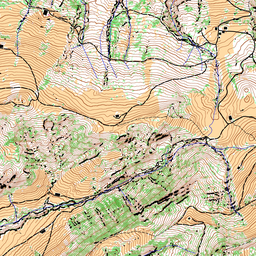

In [ ]:
import rasterio
from PIL import Image
import numpy as np

import rasterio.merge

# Ensure query_geometry_native_crs and intersecting_tiles are available from previous cells.
# query_geometry_native_crs: The geometry to which the images should be cropped and stitched.
# intersecting_tiles: GeoDataFrame with a 'png' column containing paths to image files.

if intersecting_tiles.empty:
    # If there are no intersecting tiles, create a blank 256x256 image.
    # You can customize the color or raise an error if preferred.
    print("No intersecting tiles found. Displaying a blank image.")
    final_image = Image.new("RGB", (256, 256), color="black")
else:
    # Get the bounds of the query geometry (target extent for the merged image)
    query_bounds = query_geometry_native_crs.bounds

    # List of source PNG file paths
    source_paths = list(intersecting_tiles["png"])

    # Merge (mosaic and crop) the source images to the query_bounds
    # This operation reads each PNG, crops it to the query_bounds, and mosaics them together.
    # The output resolution will generally match the highest resolution of the input images within the bounds.
    # We specify dtype=np.uint8 assuming standard 8-bit PNGs.
    # nodata=0 means areas within query_bounds not covered by any image will be black (if RGB/L).
    try:
        mosaic_array, mosaic_transform = rasterio.merge.merge(
            source_paths,
            bounds=query_bounds,
            nodata=255,  # Use 0 as the nodata value for areas not covered
            dtype=np.uint8,  # Assuming 8-bit PNGs; adjust if necessary
        )

        # Convert the NumPy array from rasterio (bands, height, width) to a PIL Image
        num_bands = mosaic_array.shape[0]

        if num_bands == 1:
            # Grayscale image: mosaic_array is (1, H, W)
            image_data_for_pil = mosaic_array[0]  # Get (H, W)
            mode = "L"
        elif num_bands == 3:
            # RGB image: transpose from (3, H, W) to (H, W, 3)
            image_data_for_pil = np.transpose(mosaic_array, (1, 2, 0))
            mode = "RGB"
        elif num_bands == 4:
            # RGBA image: transpose from (4, H, W) to (H, W, 4)
            image_data_for_pil = np.transpose(mosaic_array, (1, 2, 0))
            mode = "RGBA"
        else:
            raise ValueError(f"Unsupported number of bands in mosaic: {num_bands}. Expected 1, 3, or 4.")

        pil_image = Image.fromarray(image_data_for_pil, mode=mode)

        # Resize the stitched image to 256x256 pixels
        # Image.Resampling.LANCZOS is a high-quality downsampling filter.
        final_image = pil_image.resize((256, 256), Image.Resampling.LANCZOS)

    except Exception as e:
        print(f"An error occurred during image processing: {e}")
        print("Displaying a blank image as a fallback.")
        final_image = Image.new("RGB", (256, 256), color="red")  # Error placeholder

# Display the final 256x256 image
# In a Jupyter Notebook, the last expression being a PIL Image object will display it.
final_image

In [43]:
combined_tiles_gdf.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Denmark - onshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore; Spain - offshore.
- bounds: (6.0, 36.53, 12.01, 84.01)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [45]:
list(range(7, 18))

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]